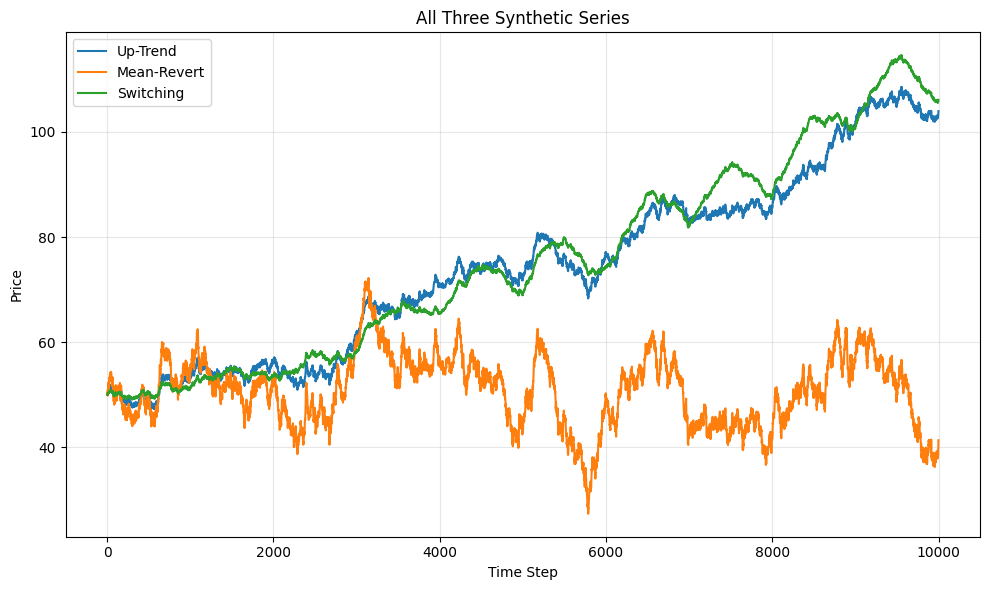

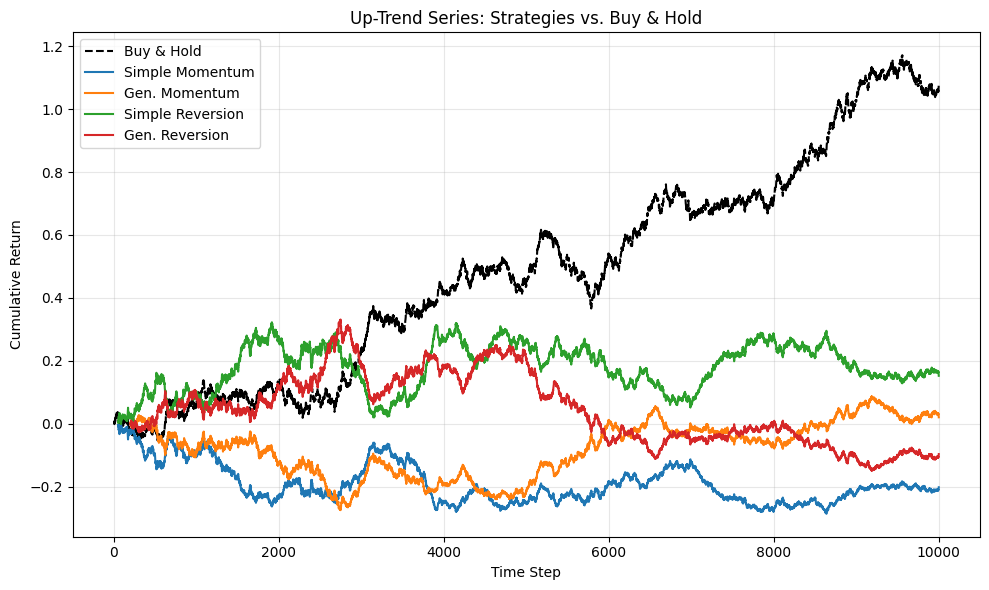

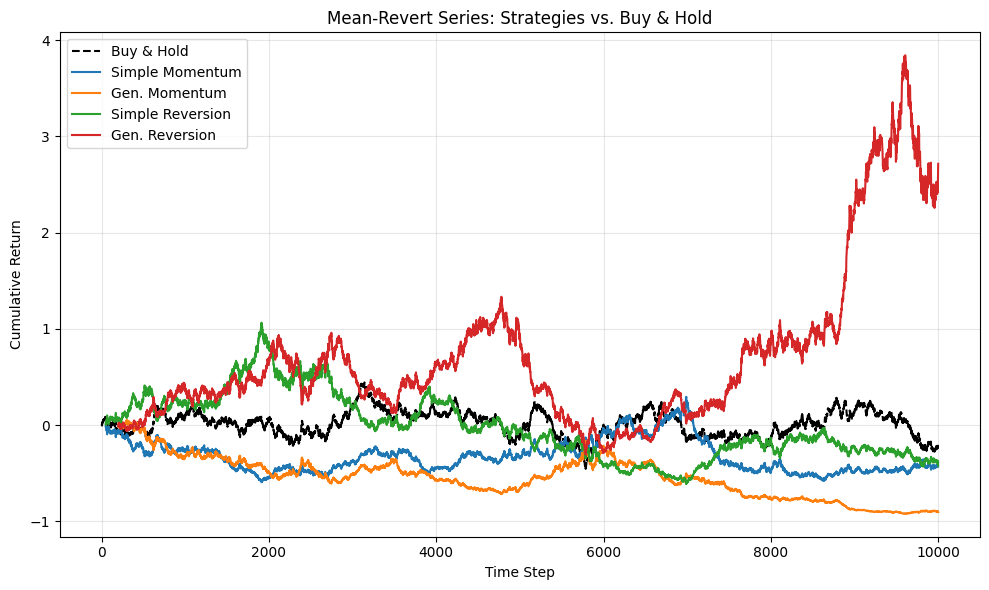

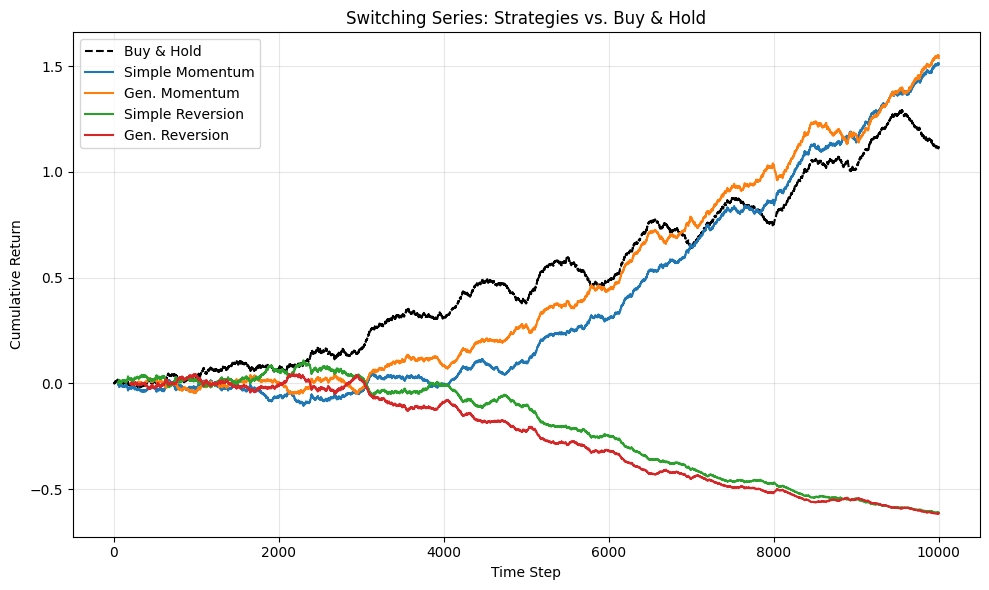

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ─── Entire Program ────────────────────────────────────────────────────────

# Strategy parameters
FAST       = 10
SLOW       = 27
WINDOW     = 10000   # length of each synthetic series

# Paper strategy params
TAU_SIMPLE = 0.0     # threshold for simple momentum/reversion
TAU_GEN    = 0.0     # threshold for generalized momentum/reversion
W_SIMPLE   = 50      # window for simple momentum/reversion
W_LONG     = 200     # long window for gen mom/rev
W_SHORT    = 50      # short window for gen mom/rev

# ─── 1. Simulation Functions (exactly as before) ──────────────────────────

def simulate_ou_standard(mu: torch.Tensor, theta: float, sigma: float, dt: float) -> torch.Tensor:
    T = mu.shape[0]
    sqrt_dt = torch.sqrt(torch.tensor(dt))
    P = torch.empty(T)
    P[0] = mu[0]
    for t in range(1, T):
        drift     = theta * (mu[t] - P[t-1]) * dt
        diffusion = sigma * sqrt_dt * torch.randn(())
        P[t] = P[t-1] + drift + diffusion
    return P

def simulate_ou_switching(mu: torch.Tensor, theta_pos: float, theta_neg: float,
                          sigma: float, dt: float, switch_interval: int) -> torch.Tensor:
    T = mu.shape[0]
    sqrt_dt = torch.sqrt(torch.tensor(dt))
    P = torch.empty(T)
    P[0] = mu[0]
    for t in range(1, T):
        theta = theta_pos if ((t // switch_interval) % 2) == 0 else theta_neg
        drift     = theta * (mu[t] - P[t-1]) * dt
        diffusion = sigma * sqrt_dt * torch.randn(())
        P[t] = P[t-1] + drift + diffusion
    return P

# ─── 2. Generate Synthetic Data ──────────────────────────────────────────

def get_data(series_type: str) -> pd.DataFrame:
    """
    series_type: 'trend', 'flat', or 'switch'
    returns a DataFrame with columns ['Price'] of length WINDOW
    """
    # OU parameters
    T           = WINDOW
    dt          = 1.0 / T
    trend_rate  = 0.01
    sigma_trend = 20.0
    sigma_flat  = 50.0
    sigma_switch= 10.0
    theta_trend = 2.0
    theta_flat  = 20.0
    theta_pos   = 7.5
    theta_neg   = -2.5
    regime_len  = 500

    # reproducibility
    torch.manual_seed(42)

    # Build mean series
    mu_trend  = 50.0 + trend_rate * torch.arange(T, dtype=torch.float)
    mu_flat   = torch.full((T,), 50.0)
    mu_switch = mu_trend.clone()

    # Simulate
    if series_type == 'trend':
        P = simulate_ou_standard(mu_trend, theta_trend, sigma_trend, dt)
    elif series_type == 'flat':
        P = simulate_ou_standard(mu_flat, theta_flat, sigma_flat, dt)
    elif series_type == 'switch':
        P = simulate_ou_switching(mu_switch, theta_pos, theta_neg,
                                  sigma_switch, dt, switch_interval=regime_len)
    else:
        raise ValueError("series_type must be 'trend', 'flat' or 'switch'")

    return pd.DataFrame({'Price': P.numpy()})

# ─── 3. Strategy Definitions ──────────────────────────────────────────────

def add_simple_mom_strategy(df: pd.DataFrame, window: int, tau: float=0.0) -> pd.DataFrame:
    df = df.copy()
    df[f'{window}_ma'] = df['Price'].rolling(window).mean()
    df['MomDiff']      = df['Price'] - df[f'{window}_ma']
    df['Strategy']     = np.where(df['MomDiff'] > tau, 1,
                                  np.where(df['MomDiff'] < -tau, -1, 0))
    df['Strategy']     = df['Strategy'].shift(1)
    return df.dropna()

def add_gen_mom_strategy(df: pd.DataFrame, long: int, short: int, tau: float=0.0) -> pd.DataFrame:
    df = df.copy()
    df[f'{long}_ma']  = df['Price'].rolling(long).mean()
    df[f'{short}_ma'] = df['Price'].rolling(short).mean()
    df['Diff']        = df[f'{short}_ma'] - df[f'{long}_ma']
    df['Strategy']    = np.where(df['Diff'] > tau, 1,
                                 np.where(df['Diff'] < -tau, -1, 0))
    df['Strategy']    = df['Strategy'].shift(1)
    return df.dropna()

def add_simple_rev_strategy(df: pd.DataFrame, window: int, tau: float=0.0) -> pd.DataFrame:
    df = add_simple_mom_strategy(df, window, tau)
    df['Strategy'] *= -1
    return df

def add_gen_rev_strategy(df: pd.DataFrame, long: int, short: int, tau: float=0.0) -> pd.DataFrame:
    df = add_gen_mom_strategy(df, long, short, tau)
    df['Strategy'] *= -1
    return df

# ─── 4. Plotting ─────────────────────────────────────────────────────────

def plot_all_series():
    series_types = [
        ('Up-Trend',   'trend'),
        ('Mean-Revert','flat'),
        ('Switching',  'switch'),
    ]
    plt.figure(figsize=(10, 6))
    for name, kind in series_types:
        df = get_data(kind)
        plt.plot(df['Price'], label=name)
    plt.title("All Three Synthetic Series")
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_strategies_vs_bh(series_name: str, kind: str):
    # Buy & Hold
    df_bh = get_data(kind)
    df_bh['Return']         = df_bh['Price'].pct_change()
    df_bh['Asset_Returns']  = (1 + df_bh['Return']).cumprod() - 1

    plt.figure(figsize=(10, 6))
    plt.plot(df_bh['Asset_Returns'], linestyle='--', color='black', label='Buy & Hold')

    # Paper strategies
    strat_list = [
        ('Simple Momentum', add_simple_mom_strategy, (W_SIMPLE, TAU_SIMPLE)),
        ('Gen. Momentum',    add_gen_mom_strategy,    (W_LONG,   W_SHORT,  TAU_GEN)),
        ('Simple Reversion', add_simple_rev_strategy, (W_SIMPLE, TAU_SIMPLE)),
        ('Gen. Reversion',   add_gen_rev_strategy,    (W_LONG,   W_SHORT,  TAU_GEN)),
    ]

    for label, func, params in strat_list:
        df_strat = func(get_data(kind), *params)
        df_strat['Return']           = df_strat['Price'].pct_change()
        df_strat['Strategy_Returns'] = (1 + df_strat['Return'] * df_strat['Strategy']).cumprod() - 1
        plt.plot(df_strat['Strategy_Returns'], label=label)

    plt.title(f"{series_name} Series: Strategies vs. Buy & Hold")
    plt.xlabel("Time Step")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Plot 1: All three synthetic series
    plot_all_series()

    # Plots 2–4: Each series' strategies vs. buy & hold
    plot_strategies_vs_bh("Up-Trend",    "trend")
    plot_strategies_vs_bh("Mean-Revert", "flat")
    plot_strategies_vs_bh("Switching",   "switch")
